# General imports

In [1]:
import numpy as np
from glob import glob
from pathlib import Path

from multiview_prediction_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_prediction_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_prediction_toolkit.config import DATA_FOLDER

from multiview_prediction_toolkit.segmentation import (
    LookUpSegmentor,
    SegmentorPhotogrammetryCameraSet,
)

2023-11-09 14:08:05:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmp2i5qwvhj


# Processing parameters

In [2]:
# Processing parameters
HEIGHT_ABOVE_GROUND_THRESH = 2
MESH_DOWNSAMPLE_TARGET = 0.25
AGGREGATE_IMAGE_SCALE = 0.25
BUFFER_RADIUS_METER = 50
NUM_CLASSES = 10

## Raw input data
# Path to labels from field data
LABELS_FILENAME = Path(
    DATA_FOLDER, "example_Emerald_Point_data", "inputs", "labels.geojson"
)
# The mesh exported from Metashape
MESH_FILENAME = Path(DATA_FOLDER, "example_Emerald_Point_data", "inputs", "mesh.ply")
# The camera file exported from Metashape
CAMERAS_FILENAME = Path(
    DATA_FOLDER, "example_Emerald_Point_data", "inputs", "cameras.xml"
)
# The digital elevation map exported by Metashape
DTM_FILE = Path(DATA_FOLDER, "example_Emerald_Point_data", "inputs", "dtm.tif")
# The image folder used to create the Metashape project
IMAGE_FOLDER = Path(DATA_FOLDER, "example_Emerald_Point_data", "inputs", "images")

## Intermediate data from previous steps
PREDICTED_IMAGE_LABELS_FOLDER = Path(
    DATA_FOLDER,
    "example_Emerald_Point_data",
    "intermediate_results",
    "predicted_segmentations",
)

# Load the mesh

In [3]:
mesh = TexturedPhotogrammetryMesh(MESH_FILENAME)

# Load the camera set and subsample

In [4]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_near_geofile(
    LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)

Loading GPS data for camera set: 100%|██████████| 915/915 [00:00<00:00, 969.56it/s] 


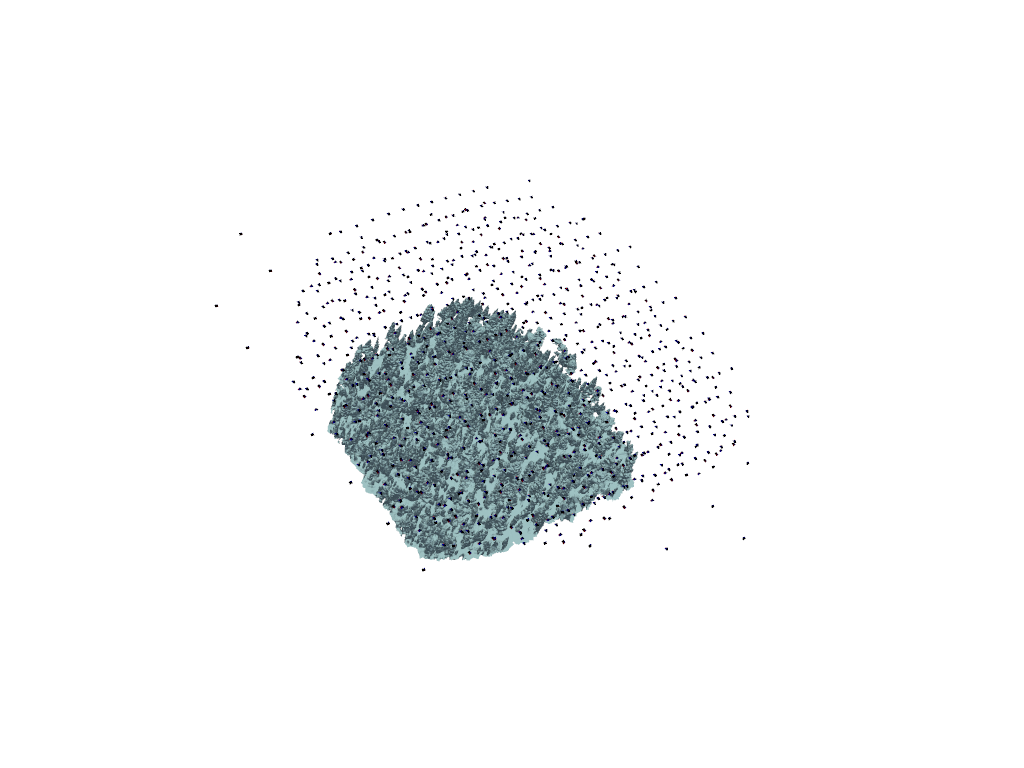

In [5]:
mesh.vis(camera_set=camera_set, force_xvfb=True)

In [6]:
segmentor = LookUpSegmentor(
    base_folder=IMAGE_FOLDER,
    lookup_folder=PREDICTED_IMAGE_LABELS_FOLDER,
    num_classes=NUM_CLASSES,
)

segmentor_camera_set = SegmentorPhotogrammetryCameraSet(
    training_camera_set, segmentor=segmentor
)

In [7]:
averaged_label_IDs, _, _ = mesh.aggregate_viewpoints_pytorch3d(
    segmentor_camera_set,
    image_scale=AGGREGATE_IMAGE_SCALE,
)

100%|██████████| 754/754 [21:53<00:00,  1.74s/it]


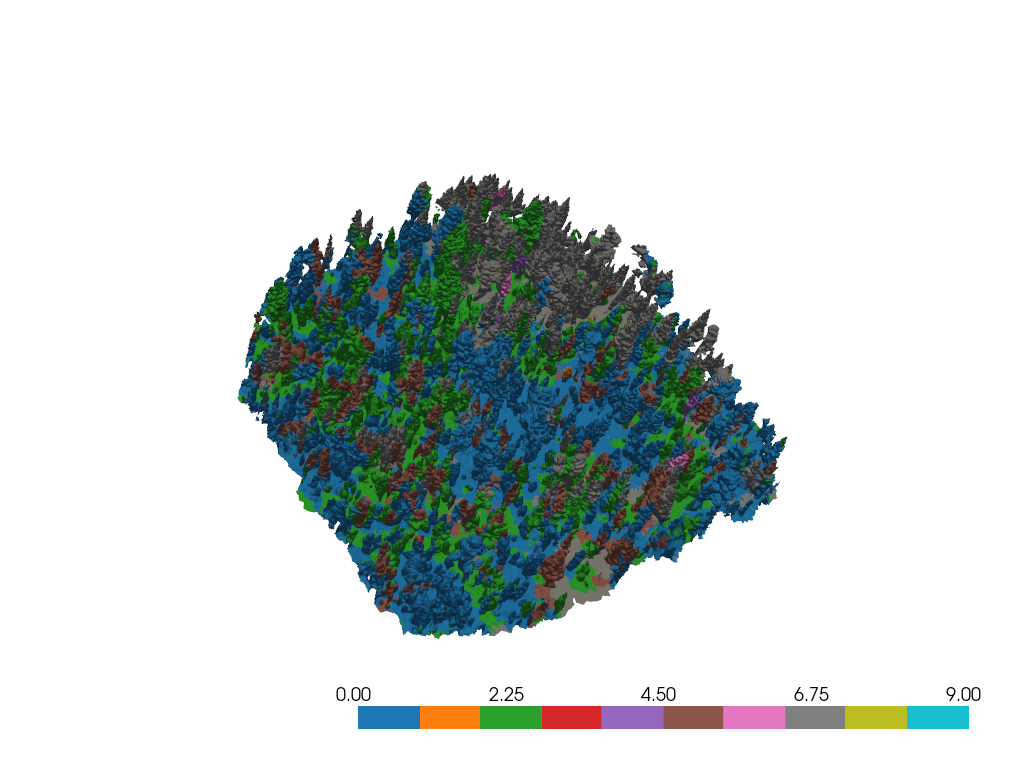

In [9]:
max_class = np.argmax(averaged_label_IDs, axis=1, keepdims=True)
mesh.vis(vis_scalars=max_class)